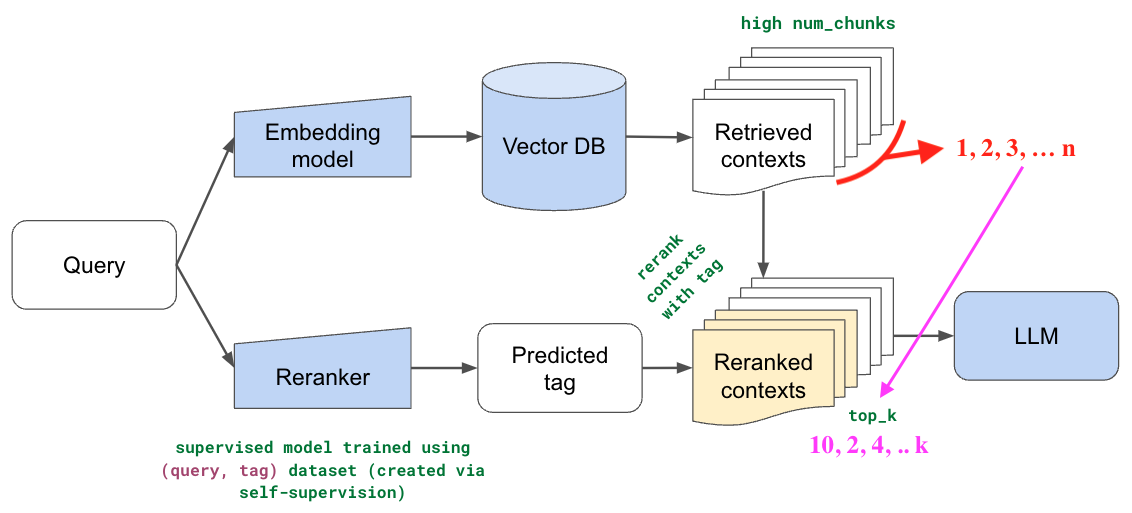

# Problem Statement:


In a typical RAG pipeline, LLM Context window is limited so for a hypothetical 10000 pages document, we need to chunk the document. For any incoming user query, we need to fetch `Top-N` related chunks and because neither our Embedding are 100% accurate nor search algo is perfect, it could give us unrelated results too. This is a flaw in RAG pipeline. How can you deal with it? If you fetch Top-1 and the context is different then it's a sure bad answer. On the other hand, if you fetch more chunks and pass to LLM, it'll get confused and with higher number, it'll go out of context.

# What's the remedy?

Out of all the methods available, Re-ranking is the simplest. Idea is pretty simple.


1. You assume that Embedding + Search algo are not 100% precise so you use Recall to your advantage and get similar high `N` (say 25) number of related chunks from corpus.

2. Second step is to use a powerful model to increase the Precision. You re-rank above `N` queries again so that you can change the relative ordering and now select Top `K` queries (say 3) to pass as a context where `K` < `N` thus increasing the Precision.


# Why can't you use the bigger model in the first place?
Would your search results be better if you were searching in 100 vs 100000 documents? Yes, so no matter how big of a model you use, you'll always have some irrelevent results because of the huge domain.


Smaller model with efficient searching algo does the work of searching in a bigger domain to get more number of elements while the larger model is precise and because it just works on `K`, there is a bit more overhead but improved relevancy.


In [ ]:
!pip install -U lancedb transformers datasets FlagEmbedding unstructured langchain -qq

# NOTE: If there is an import error, restart and run the notebook again

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
from FlagEmbedding import LLMEmbedder, FlagReranker # Al document present here https://github.com/FlagOpen/FlagEmbedding/tree/master
import os
import lancedb
import re
import pandas as pd
import random

from datasets import load_dataset

import torch
import gc

import lance
from lancedb.embeddings import with_embeddings


task = "qa" # Encode for a specific task (qa, icl, chat, lrlm, tool, convsearch)
embed_model = LLMEmbedder('BAAI/llm-embedder', use_fp16=False) # Load model (automatically use GPUs)

reranker_model = FlagReranker('BAAI/bge-reranker-base', use_fp16=True) # use_fp16 speeds up computation with a slight performance degradation

# For basic splitting
# basic_text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=64,) # 512 is the default Embedding model max_len

# For Advanced Usage: https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/split_by_token
# embedder_tokenizer = AutoTokenizer.from_pretrained("BAAI/llm-embedder") # Advanced Tokenizer Splitter Strategy
# advanced_text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder_tokenizer, chunk_size=512, chunk_overlap=0)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

# Load `Chunks` of data from [BeIR Dataset](https://huggingface.co/datasets/BeIR/scidocs)

Note: This is a dataset built specially for retrieval tasks to see how good your search is working

In [ ]:
queries = load_dataset("BeIR/scidocs", "queries")["queries"].to_pandas()
docs = load_dataset('BeIR/scidocs', 'corpus')["corpus"].to_pandas().dropna(subset = "text").sample(10000) # just random samples for faster embed demo
docs.sample(3)

Generating queries split: 0 examples [00:00, ? examples/s]

Generating corpus split: 0 examples [00:00, ? examples/s]

,_id,title,text
17717,091003e11af2784e00283640c25ad6833333cdab,A High Efficiency two-stage ZVS AC/DC converte...,A High Efficiency two-stage AC/DC converter is...
4151,b02771eb27df3f69d721cfd64e13e338acbc3336,End-to-End Conversion of HTML Tables for Popul...,Automating the conversion of human-readable HT...
12644,1470c07ac3b1f60f640bb70f8c64b4d7fcc50f69,A high accuracy solver for RTE in underwater o...,"In this paper, we present a new improved numer..."


# Get embedding using [`LLM embedder`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/llm_embedder) and create Database using [`LanceDB`](https://github.com/lancedb/lancedb)

In [ ]:
def embed_documents(batch):
    """
    Function to embed the whole text data
    """
    return embed_model.encode_keys(batch, task=task) # Encode data or 'keys'


db = lancedb.connect("./db") # Connect Local DB
if "doc_embed" in db.table_names():
  table = db.open_table("doc_embed") # Open Table
else:
  # Use the train text chunk data to save embed in the DB
  data = with_embeddings(embed_documents, docs, column = 'text',show_progress = True, batch_size = 128)
  table = db.create_table("doc_embed", data=data) # create Table

  0%|          | 0/79 [00:00<?, ?it/s]

# Search from a random Text

In [ ]:
def search(query, top_k = 10):
  """
  Search a query from the table
  """
  query_vector = embed_model.encode_queries(query, task=task) # Encode the QUERY (it is done differently than the 'key')
  search_results = table.search(query_vector).limit(top_k)
  return search_results


query = random.choice(queries["text"])
print("QUERY:-> ", query)

# get top_k search results
search_results = search("what is mitochondria?", top_k = 10).to_pandas().dropna(subset = "text").reset_index(drop = True)

search_results

QUERY:->  Improving Naive Bayes Classifier Using Conditional Probabilities


,_id,title,text,vector,_distance
0,a3345798b1faf238e8d805bbe9124b0b8e0c869f,Autophagy as a regulated pathway of cellular d...,Macroautophagy is a dynamic process involving ...,"[-0.042504966, 0.0005350402, -0.016986115, 0.0...",0.312909
1,8f5d905a63dc11f3895949c05c73a660d73aa4b7,Timing to Perfection: The Biology of Central a...,"The mammalian circadian system, which is compr...","[0.005047991, 0.044294164, -0.0116344, -0.0144...",0.360853
2,cbf4040cb14a019ff3556fad5c455e99737f169f,Answering Schrödinger's question: A free-energ...,The free-energy principle (FEP) is a formal mo...,"[-0.010098294, 0.01394069, 0.00059502176, 0.01...",0.366217
3,55f0f716a355adc7e29593bf650590b1a5a552b5,Cell biology of protein misfolding: The exampl...,The salutary intersection of fundamental cell ...,"[-0.03869332, -0.0055972184, -0.041978512, -0....",0.369358
4,c65945c08b7fd77ffd2c53369e8928699c3993e7,Comparing Alzheimer’s and Parkinson’s diseases...,Recent advances in large datasets analysis off...,"[-0.004613002, -0.0044279, -0.013920471, 0.002...",0.369777
5,244fc78ce607812edb90290727dab4d33377e986,Transfer of mitochondria via tunneling nanotub...,Tunneling nanotubes (TNTs) are F-actin-based m...,"[-0.006337583, 0.00634843, -0.03423933, 0.0077...",0.380112
6,d25ceed5ff16bff36e0c91549e51501e6ca4ddb0,CO2 bio-mitigation using microalgae,Microalgae are a group of unicellular or simpl...,"[0.034966998, 0.028465202, -0.015458229, 0.022...",0.381480
7,abeaf3f4cb5ee4acf9d13b5dfa0ee1e04ef1c620,Logic-Based Models for the Analysis of Cell Si...,Computational models are increasingly used to ...,"[-0.016860971, 0.039416213, -0.042567477, -0.0...",0.381614
8,f8be08195b1a7e9e45028eee4844ea2482170a3e,Gut microbiota functions: metabolism of nutrie...,The diverse microbial community that inhabits ...,"[0.027819231, 0.03366638, -0.024391498, 0.0026...",0.382530
9,706418cef23f6b0cc480426a1f4fe564a298dece,Biological network analysis and comparison: mi...,The mechanisms underlying life machinery are s...,"[0.034432467, 0.023537781, -0.03238645, -0.036...",0.385442


# Rerank Search Results using Reranker from [`BGE Reranker`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/reranker)

Pass all the results to a stronger model to give them the similarity ranking

In [ ]:
def rerank(query, search_results):
  search_results["old_similarity_rank"] = search_results.index+1 # Old ranks

  torch.cuda.empty_cache()
  gc.collect()

  search_results["new_scores"] = reranker_model.compute_score([[query,chunk] for chunk in search_results["text"]]) # Re compute ranks
  return search_results.sort_values(by = "new_scores", ascending = False).reset_index(drop = True)

print("QUERY:-> ", query)

rerank(query, search_results)

QUERY:->  Improving Naive Bayes Classifier Using Conditional Probabilities


,_id,title,text,vector,_distance,old_similarity_rank,new_scores
0,706418cef23f6b0cc480426a1f4fe564a298dece,Biological network analysis and comparison: mi...,The mechanisms underlying life machinery are s...,"[0.034432467, 0.023537781, -0.03238645, -0.036...",0.385442,10,-9.945312
1,cbf4040cb14a019ff3556fad5c455e99737f169f,Answering Schrödinger's question: A free-energ...,The free-energy principle (FEP) is a formal mo...,"[-0.010098294, 0.01394069, 0.00059502176, 0.01...",0.366217,3,-9.960938
2,a3345798b1faf238e8d805bbe9124b0b8e0c869f,Autophagy as a regulated pathway of cellular d...,Macroautophagy is a dynamic process involving ...,"[-0.042504966, 0.0005350402, -0.016986115, 0.0...",0.312909,1,-10.195312
3,8f5d905a63dc11f3895949c05c73a660d73aa4b7,Timing to Perfection: The Biology of Central a...,"The mammalian circadian system, which is compr...","[0.005047991, 0.044294164, -0.0116344, -0.0144...",0.360853,2,-10.195312
4,55f0f716a355adc7e29593bf650590b1a5a552b5,Cell biology of protein misfolding: The exampl...,The salutary intersection of fundamental cell ...,"[-0.03869332, -0.0055972184, -0.041978512, -0....",0.369358,4,-10.195312
5,c65945c08b7fd77ffd2c53369e8928699c3993e7,Comparing Alzheimer’s and Parkinson’s diseases...,Recent advances in large datasets analysis off...,"[-0.004613002, -0.0044279, -0.013920471, 0.002...",0.369777,5,-10.195312
6,244fc78ce607812edb90290727dab4d33377e986,Transfer of mitochondria via tunneling nanotub...,Tunneling nanotubes (TNTs) are F-actin-based m...,"[-0.006337583, 0.00634843, -0.03423933, 0.0077...",0.380112,6,-10.195312
7,d25ceed5ff16bff36e0c91549e51501e6ca4ddb0,CO2 bio-mitigation using microalgae,Microalgae are a group of unicellular or simpl...,"[0.034966998, 0.028465202, -0.015458229, 0.022...",0.381480,7,-10.195312
8,abeaf3f4cb5ee4acf9d13b5dfa0ee1e04ef1c620,Logic-Based Models for the Analysis of Cell Si...,Computational models are increasingly used to ...,"[-0.016860971, 0.039416213, -0.042567477, -0.0...",0.381614,8,-10.195312
9,f8be08195b1a7e9e45028eee4844ea2482170a3e,Gut microbiota functions: metabolism of nutrie...,The diverse microbial community that inhabits ...,"[0.027819231, 0.03366638, -0.024391498, 0.0026...",0.382530,9,-10.195312
